# Import Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import cv2
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout,SpatialDropout2D
from tensorflow.keras.models  import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import random,os,glob
import matplotlib.pyplot as plt

## Dataset Input

In [0]:
dir_path = '/content/drive/My Drive/Garbage/garbage-classification/Garbage classification/Garbage classification'

In [0]:
img_list = glob.glob(os.path.join(dir_path, '*/*.jpg'))

In [7]:
len(img_list)

2527

# Image Augmentation

In [8]:
train=ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255,
                         shear_range = 0.1,
                         zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)

test=ImageDataGenerator(rescale=1/255,
                        validation_split=0.1)

train_generator=train.flow_from_directory(dir_path,
                                          target_size=(300,300),
                                          batch_size=32,
                                          class_mode='categorical',
                                          subset='training')

test_generator=test.flow_from_directory(dir_path,
                                        target_size=(300,300),
                                        batch_size=32,
                                        class_mode='categorical',
                                        subset='validation')

labels = (train_generator.class_indices)
print(labels)

labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [9]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 300, 300, 3), (32, 6))

### Writing the labels file

In [10]:
print (train_generator.class_indices)

Labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(Labels)


{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


# InceptionV3 model with own classifier

In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras_preprocessing.image import ImageDataGenerator
import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import optimizers, losses
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
import pickle



base_model = InceptionV3( include_top=False, input_shape=(300, 300, 3))
#base_model.load_weights('../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)

predictions = Dense(6, activation='softmax')(x) 
model = Model(inputs=base_model.input, outputs=predictions)

opt = Nadam(lr=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

batch_size = 200
epochs = 100

steps_per_epoch = train_generator.n // batch_size
validation_steps = test_generator.n // batch_size



Training the model

In [38]:
checkpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5', monitor='val_acc', verbose=1, save_best_only=True)
history = model.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=test_generator, validation_steps=validation_steps,
                              callbacks=[checkpointer])
with open('trainHistoryDict.txt', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
11/11 [==============================] - 191s 17s/step - loss: 1.7442 - accuracy: 0.2500 - val_loss: 1.5128 - val_accuracy: 0.3438
Epoch 2/100
 1/11 [=>............................] - ETA: 0s - loss: 1.4871 - accuracy: 0.4062

Can save best model only with val_acc available, skipping.


11/11 [==============================] - 141s 13s/step - loss: 1.4480 - accuracy: 0.4784 - val_loss: 1.2081 - val_accuracy: 0.5938
Epoch 3/100
11/11 [==============================] - 183s 17s/step - loss: 1.2449 - accuracy: 0.6222 - val_loss: 1.0792 - val_accuracy: 0.6562
Epoch 4/100
11/11 [==============================] - 191s 17s/step - loss: 1.1491 - accuracy: 0.6193 - val_loss: 0.9665 - val_accuracy: 0.7188
Epoch 5/100
11/11 [==============================] - 183s 17s/step - loss: 1.0289 - accuracy: 0.6591 - val_loss: 0.9012 - val_accuracy: 0.6875
Epoch 6/100
11/11 [==============================] - 180s 16s/step - loss: 0.9803 - accuracy: 0.7017 - val_loss: 0.8529 - val_accuracy: 0.7500
Epoch 7/100
11/11 [==============================] - 100s 9s/step - loss: 0.8811 - accuracy: 0.7301 - val_loss: 0.8947 - val_accuracy: 0.6562
Epoch 8/100
11/11 [==============================] - 9s 803ms/step - loss: 0.8141 - accuracy: 0.7472 - val_loss: 0.8829 - val_accuracy: 0.6562
Epoch 9/100


Classification by InceptionV3

Maximum Probability:  0.99840695
Classified: plastic


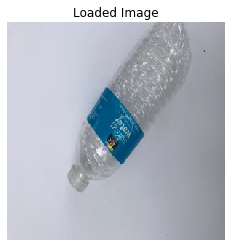

In [39]:
from keras.preprocessing import image

img_path = dir_path+'/plastic/plastic75.jpg'

img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())

p=model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)



# Accuracy Graph

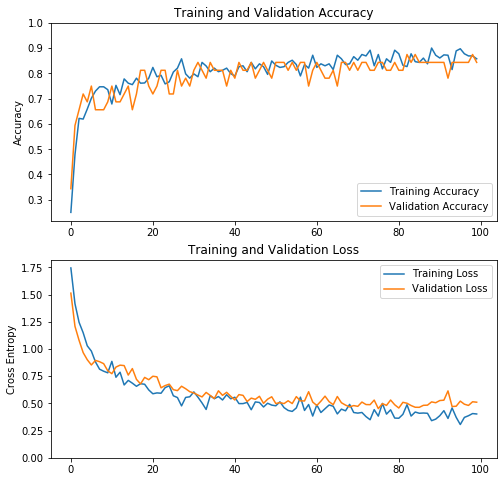

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

# SHAP Explainer

In [11]:
!pip install shap
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import shap
import keras.backend as K
import json

shap.initjs()


# utility function to visualize SHAP values in larger image formats
# this modifies the `shap.image_plot(...)` function
def visualize_model_decisions(shap_values, x, labels=None, figsize=(20, 30)):
    
    colors = []
    for l in np.linspace(1, 0, 100):
        colors.append((30./255, 136./255, 229./255,l))
    for l in np.linspace(0, 1, 100):
        colors.append((255./255, 13./255, 87./255,l))
    red_transparent_blue = LinearSegmentedColormap.from_list("red_transparent_blue", colors)

    multi_output = True
    if type(shap_values) != list:
        multi_output = False
        shap_values = [shap_values]

    # make sure labels
    if labels is not None:
        assert labels.shape[0] == shap_values[0].shape[0], "Labels must have same row count as shap_values arrays!"
        if multi_output:
            assert labels.shape[1] == len(shap_values), "Labels must have a column for each output in shap_values!"
        else:
            assert len(labels.shape) == 1, "Labels must be a vector for single output shap_values."

    # plot our explanations
    fig_size = figsize
    fig, axes = plt.subplots(nrows=x.shape[0], ncols=len(shap_values) + 1, figsize=fig_size)
    if len(axes.shape) == 1:
        axes = axes.reshape(1,axes.size)
    for row in range(x.shape[0]):
        x_curr = x[row].copy()

        # make sure
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 1:
            x_curr = x_curr.reshape(x_curr.shape[:2])
        if x_curr.max() > 1:
            x_curr /= 255.
        
        axes[row,0].imshow(x_curr)
        axes[row,0].axis('off')
        
        # get a grayscale version of the image
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 3:
            x_curr_gray = (0.2989 * x_curr[:,:,0] + 0.5870 * x_curr[:,:,1] + 0.1140 * x_curr[:,:,2]) # rgb to gray
        else:
            x_curr_gray = x_curr

        if len(shap_values[0][row].shape) == 2:
            abs_vals = np.stack([np.abs(shap_values[i]) for i in range(len(shap_values))], 0).flatten()
        else:
            abs_vals = np.stack([np.abs(shap_values[i].sum(-1)) for i in range(len(shap_values))], 0).flatten()
        max_val = np.nanpercentile(abs_vals, 99.9)
        for i in range(len(shap_values)):
            if labels is not None:
                axes[row,i+1].set_title(labels[row,i])
            sv = shap_values[i][row] if len(shap_values[i][row].shape) == 2 else shap_values[i][row].sum(-1)
            axes[row,i+1].imshow(x_curr_gray, cmap=plt.get_cmap('gray'), alpha=0.15, extent=(-1, sv.shape[0], sv.shape[1], -1))
            im = axes[row,i+1].imshow(sv, cmap=red_transparent_blue, vmin=-max_val, vmax=max_val)
            axes[row,i+1].axis('off')
        
    cb = fig.colorbar(im, ax=np.ravel(axes).tolist(), label="SHAP value", orientation="horizontal", aspect=fig_size[0]/0.2)
    cb.outline.set_visible(False)

     |████████████████████████████████| 266kB 7.1MB/s 
  Created wheel for shap: filename=shap-0.34.0-cp36-cp36m-linux_x86_64.whl size=383191 sha256=6e7bc5c9e9325567647d924d66393216950db8c77d3de41dbdc861fc03b6df09
  Stored in directory: /root/.cache/pip/wheels/28/7e/28/57bc9fcb77579b0df6561298648249370648c0b91dfe42c8ec
Successfully built shap


In [95]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 149, 149, 32) 96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 149, 149, 32) 0           batch_normalization_376[0][0]    
____________________________________________________________________________________________

In [94]:

e = shap.GradientExplainer(model, img.reshape(1,300,300,3))
shap_values,indexes = e.shap_values(img.reshape(1,300,300,3), ranked_outputs=2)
print(indexes)
index_names = np.vectorize(lambda x: labels[x])(indexes)
index_names

[[3 0]]


array([['paper', 'cardboard']], dtype='<U9')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


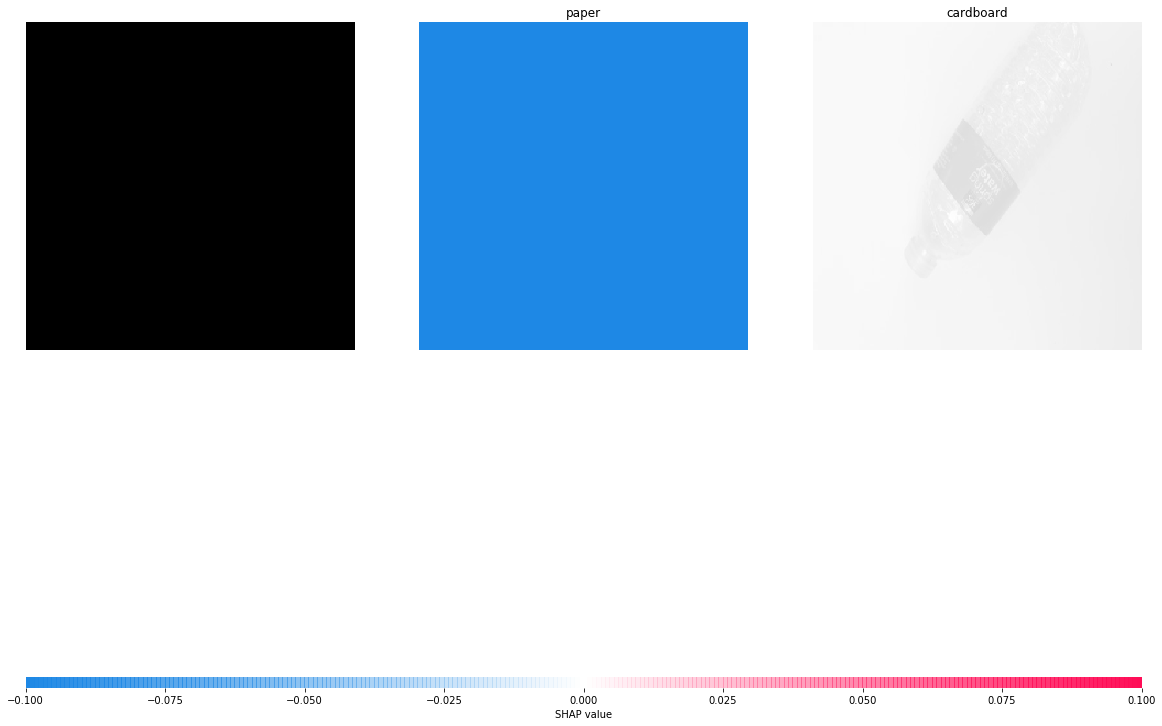

In [92]:
visualize_model_decisions(shap_values=shap_values, x=img.reshape(1,300,300,3), 
                          labels=index_names, figsize=(20, 40))

In [12]:
!pip install tf-explain
!pip install pillow
!pip install tensorflow-gpu==2.0.0b1

     |████████████████████████████████| 51kB 3.7MB/s 
     |████████████████████████████████| 348.9MB 47kB/s 
     |████████████████████████████████| 501kB 15.4MB/s 
     |████████████████████████████████| 3.1MB 39.4MB/s 


Intermediate Layer Vizualation

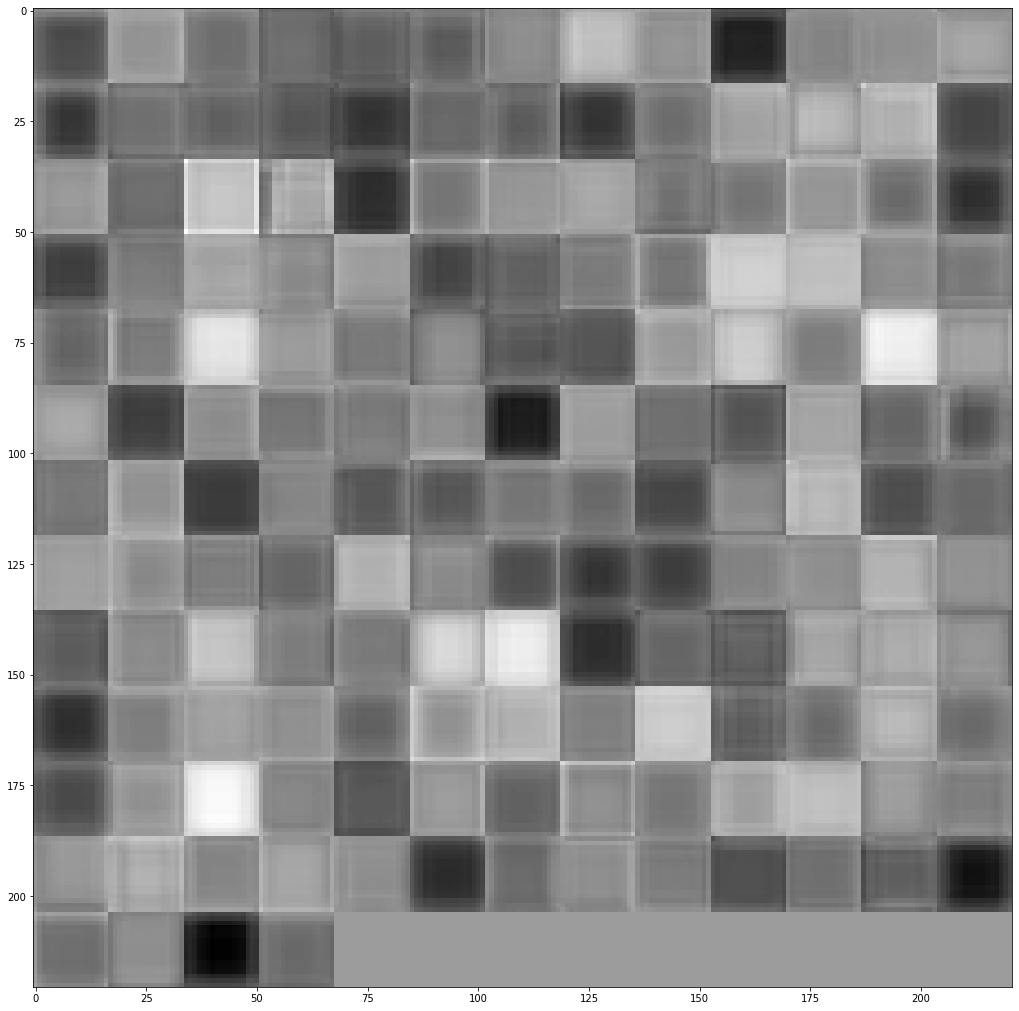

In [96]:
from tf_explain.core.activations import ExtractActivations
explainer = ExtractActivations()
grid = explainer.explain((np.array([img]), None), model, ['conv2d_420'])
fig, ax = plt.subplots(figsize=(18, 18))
ax.imshow(grid, cmap='binary_r')

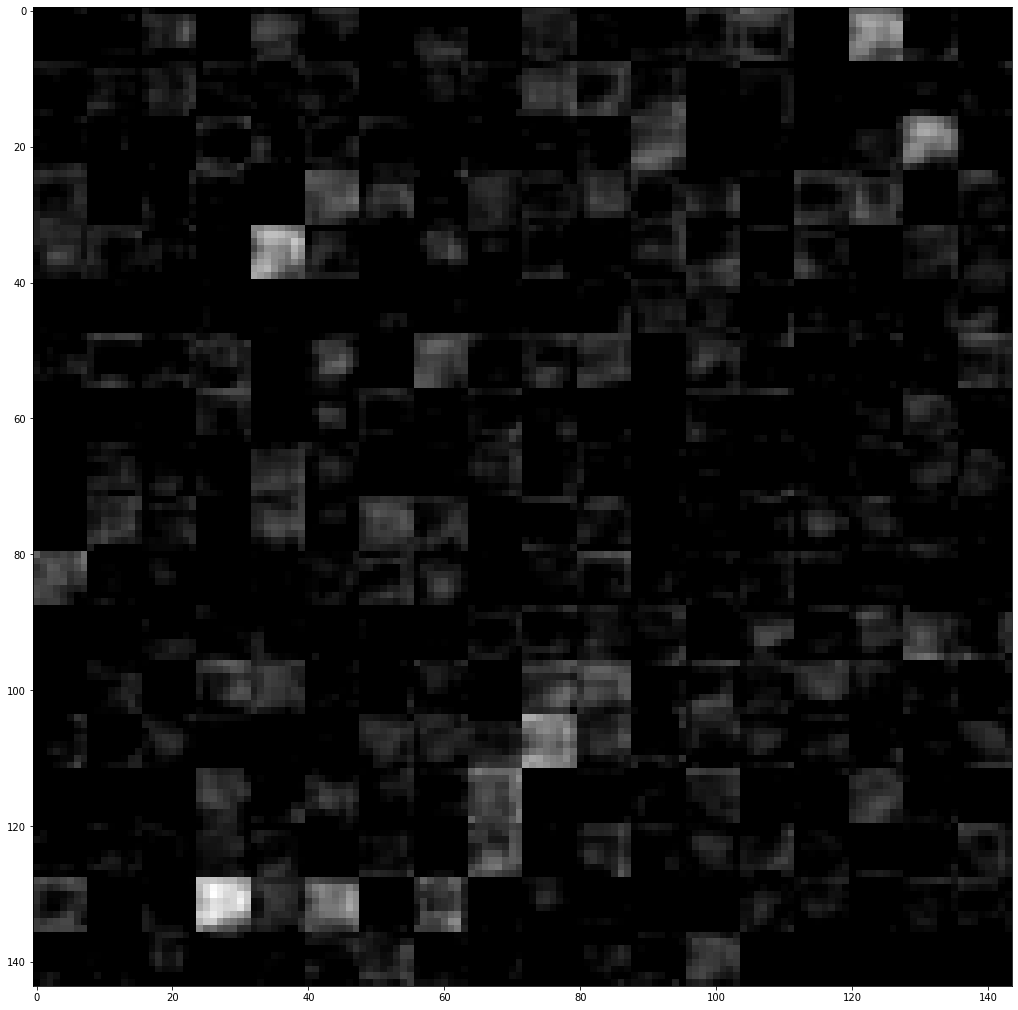

In [98]:
from tf_explain.core.activations import ExtractActivations
explainer = ExtractActivations()
grid = explainer.explain((np.array([img]), None), model, ['activation_461'])
fig, ax = plt.subplots(figsize=(18, 18))
ax.imshow(grid, cmap='binary_r')

# VGG16 with own classifier

In [13]:
from tensorflow.keras.applications.vgg16 import VGG16
from keras_preprocessing.image import ImageDataGenerator
import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import optimizers, losses
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
import pickle



base_model = VGG16( include_top=False, input_shape=(300, 300, 3))
#base_model.load_weights('../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)

predictions = Dense(6, activation='softmax')(x) 
modelvgg = Model(inputs=base_model.input, outputs=predictions)

opt = Nadam(lr=0.0001)
modelvgg.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

batch_size = 200
epochs = 100

steps_per_epoch = train_generator.n // batch_size
validation_steps = test_generator.n // batch_size



Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 3s 0us/step


In [14]:
opt = Nadam(lr=0.0001)
modelvgg.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

batch_size = 200
epochs = 100


steps_per_epoch = train_generator.n // batch_size
validation_steps = test_generator.n // batch_size
filepath="vggtrained_model.h5"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1] 
history = modelvgg.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=test_generator, validation_steps=validation_steps,callbacks=callbacks_list)

Epoch 1/100
 1/11 [=>............................] - ETA: 2:26 - loss: 1.7747 - acc: 0.1562
Epoch 00001: val_acc improved from -inf to 0.15625, saving model to vggtrained_model.h5
11/11 [==============================] - 162s 15s/step - loss: 1.7638 - acc: 0.1989 - val_loss: 1.7747 - val_acc: 0.1562
Epoch 2/100
 1/11 [=>............................] - ETA: 3s - loss: 1.7500 - acc: 0.3125
Epoch 00002: val_acc improved from 0.15625 to 0.31250, saving model to vggtrained_model.h5
11/11 [==============================] - 134s 12s/step - loss: 1.6935 - acc: 0.2756 - val_loss: 1.7500 - val_acc: 0.3125
Epoch 3/100
 1/11 [=>............................] - ETA: 3s - loss: 1.7334 - acc: 0.1562
Epoch 00003: val_acc did not improve from 0.31250
11/11 [==============================] - 146s 13s/step - loss: 1.6643 - acc: 0.3125 - val_loss: 1.7334 - val_acc: 0.1562
Epoch 4/100
 1/11 [=>............................] - ETA: 2s - loss: 1.6630 - acc: 0.4062
Epoch 00004: val_acc improved from 0.31250 to 

Maximum Probability:  0.44324026
Classified: plastic


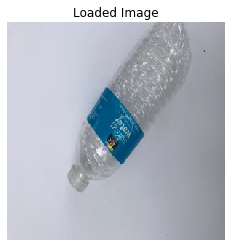

In [15]:
from keras.preprocessing import image

img_path = dir_path+'/plastic/plastic75.jpg'

img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())

p=modelvgg.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)


In [16]:
modelvgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [0]:
modelvgg.layers[3].input


<tf.Tensor 'dropout_1/cond/Merge:0' shape=(?, 512) dtype=float32>


[[4 3]]


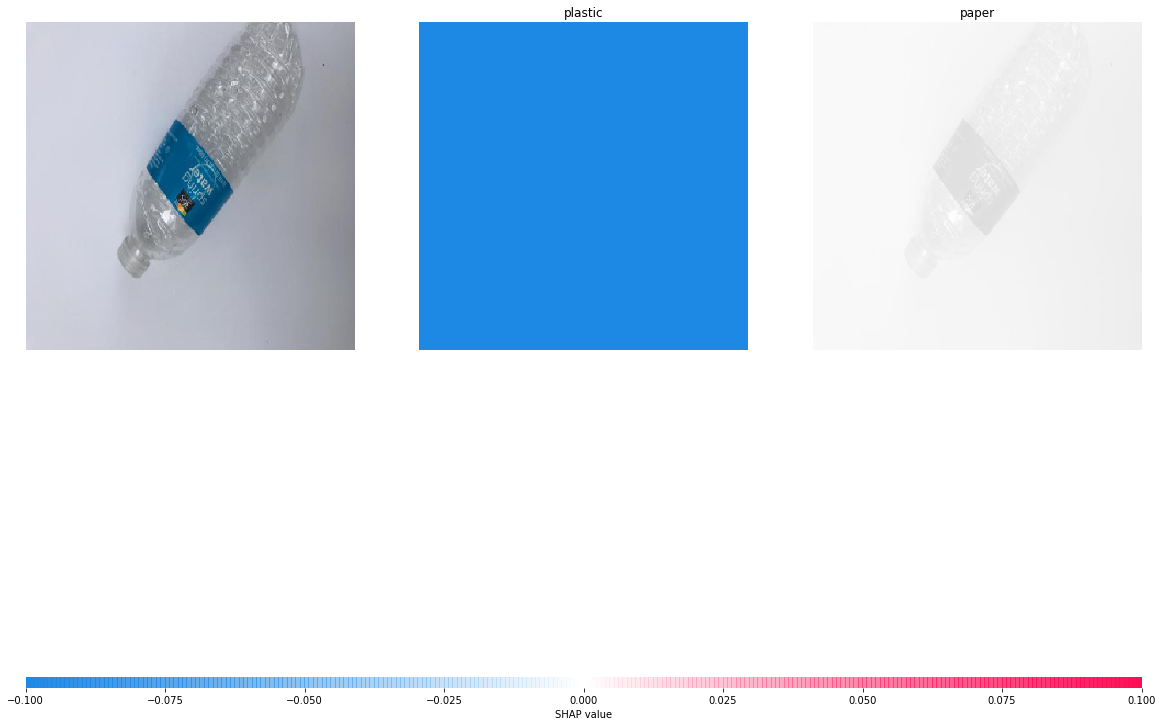

In [17]:
e = shap.GradientExplainer(modelvgg, img.reshape(1,300,300,3))
shap_values,indexes = e.shap_values(img.reshape(1,300,300,3), ranked_outputs=2)
print(indexes)
index_names = np.vectorize(lambda x: labels[x])(indexes)
index_names
visualize_model_decisions(shap_values=shap_values, x=img.reshape(1,300,300,3), 
                          labels=index_names, figsize=(20, 40))

In [18]:
!pip install tf-explain
!pip install pillow
!pip install tensorflow-gpu==2.0.0b1

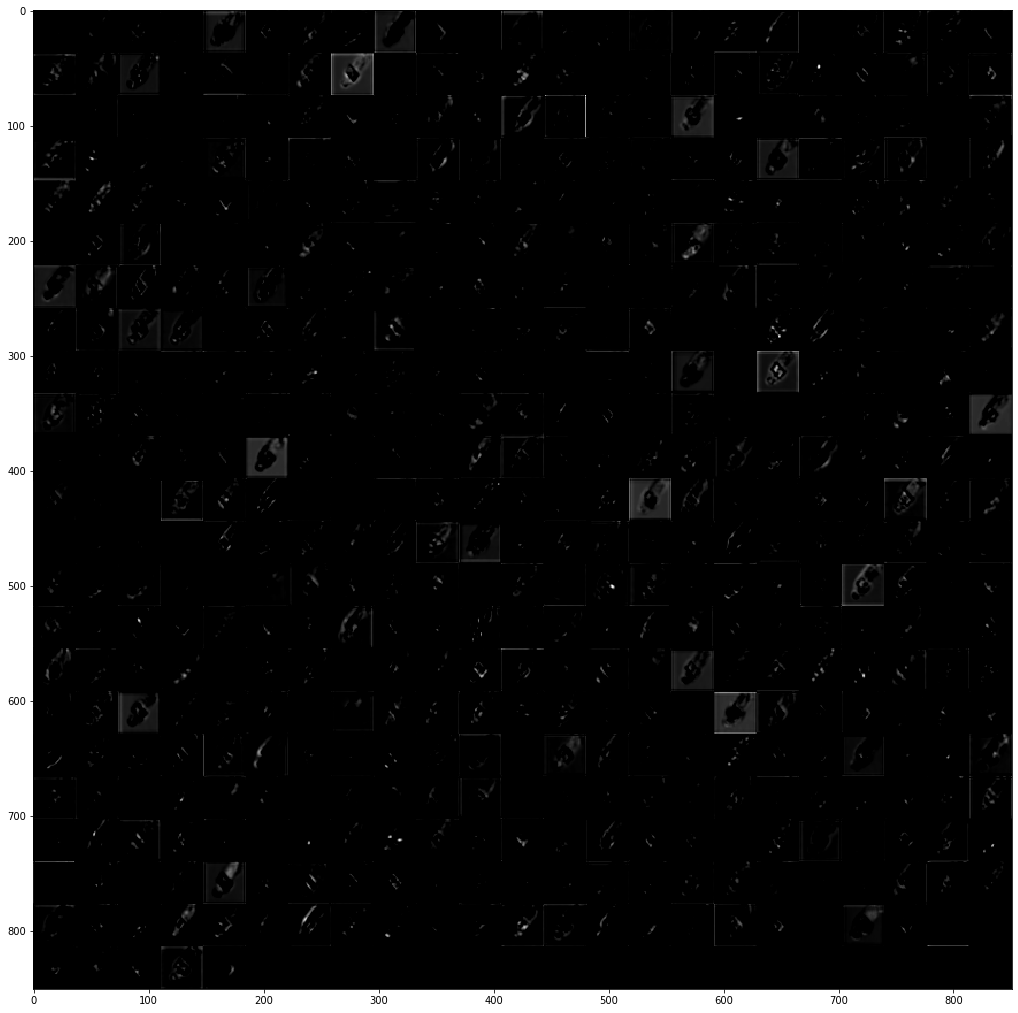

In [20]:
from tf_explain.core.activations import ExtractActivations
explainer = ExtractActivations()
grid = explainer.explain((np.array([img]), None), modelvgg, ['block4_conv3'])
fig, ax = plt.subplots(figsize=(18, 18))
ax.imshow(grid, cmap='binary_r')

# Occlusion Sensitivity

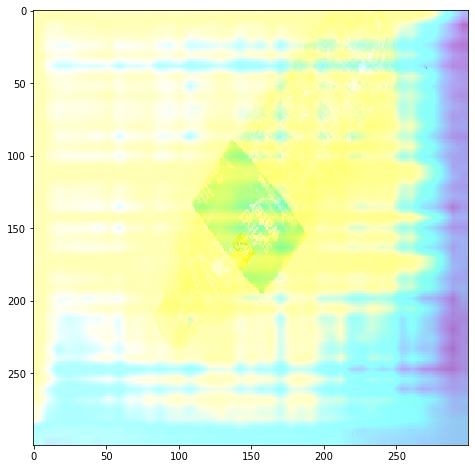

In [34]:
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity
explainer = OcclusionSensitivity()
grid = explainer.explain(([img], None), modelvgg,4, 7)
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(grid)#, alpha=1)
